In [289]:
from numpy import (dtype, int8, float32, complex64)
from numpy import (arange, zeros, pi, sqrt, cos, sin, abs, log10, random, fft)
from numpy import (real, imag)
import numpy as np
import matplotlib.pyplot as plt

# configuration parameters and signal scenario
FFT_LENGTH = 32         # transform size in pfb (a.k.a polyphase branches)
M = FFT_LENGTH
DEC_FACTOR = 24         # decimation rate, (D < M)
FINE_FFT_LENGTH = 512   # second stage transform size

OUTPUT_WINDOWS = FINE_FFT_LENGTH
Nsamps = FFT_LENGTH*OUTPUT_WINDOWS

fs = 10e3             # sample rate
fs_cs = fs/M          # critically sampled output sample rate
fs_os = fs/DEC_FACTOR # oversampled output sample rate

f = 2e3               # signal of intrest frequency

if Nsamps:
    t = Nsamps/fs
else:
    t = 0.2
    Nsamps = int(t*fs)

n = arange(0, Nsamps)
x = zeros(Nsamps, dtype=complex64)

# generate samples
signal_power = 20
noise_power = 10

signal_amp = sqrt(signal_power)
noise_amp = sqrt(noise_power/2)

omega = 2*pi*f
signal = signal_amp*(cos(omega*n/fs) + 1j*sin(omega*n/fs))
noise = noise_amp*(random.randn(Nsamps) + 1j*random.randn(Nsamps))

x = signal + noise

# quantize
d_max = 127
d_min = -128
x_real = (real(x) - d_min)/(d_max-d_min) - 0.5
x_imag = (imag(x) - d_min)/(d_max-d_min) - 0.5 

x = x_real + 1j*x_imag

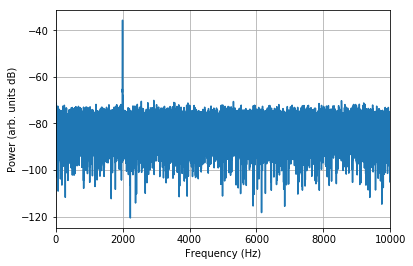

In [290]:
# plot a sample spectrum for verification of generated data
X = fft.fft(x, FFT_LENGTH*FINE_FFT_LENGTH)/(FFT_LENGTH*FINE_FFT_LENGTH)

fbins_pre = arange(0, FFT_LENGTH*FINE_FFT_LENGTH)
faxis_pre = fbins_pre*fs_cs/FINE_FFT_LENGTH

plt.plot(faxis_pre, 20*log10(abs(X)))
plt.xlim([min(faxis_pre), max(faxis_pre)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb. units dB)')
plt.grid()
plt.show()

In [291]:
# initialize PYNQ, overlay, and data buffers
import pynq
from pynq import Xlnk
from pynq import Overlay

OVERLAY_PATH = '/home/xilinx/jupyter_notebooks/alpaca/overlay/pfb_d24/os_pfb.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0

xlnk = Xlnk()

in_buffer = xlnk.cma_array(shape=(DEC_FACTOR,), dtype=complex64, cacheable=1)
out_buffer = xlnk.cma_array(shape=(FFT_LENGTH,), dtype=complex64, cacheable=1)

ospfb_output = np.zeros(shape=(FFT_LENGTH, OUTPUT_WINDOWS), dtype=complex64)

def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [292]:
# Copy samples into input buffer shifting in DEC_FACTOR new samples each transfer

for window_idx in range(0, OUTPUT_WINDOWS):
    data_idx = window_idx*DEC_FACTOR
    if not (window_idx % 31):
        print(window_idx)
    #print(i, data_idx, data_idx+(D-1), len(x[data_idx:data_idx+DEC_FACTOR]))
    np.copyto(in_buffer, x[data_idx:data_idx+DEC_FACTOR])
    dma_transfer()
    np.copyto(ospfb_output[:, window_idx], out_buffer)
print(window_idx)
    

0
31
62
93
124
155
186
217
248
279
310
341
372
403
434
465
496
511


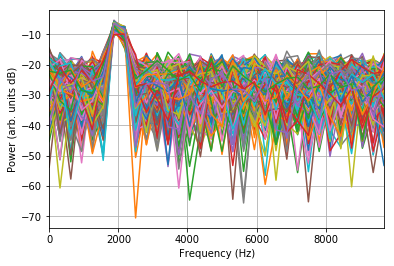

In [293]:
# plot coarse channel output
fbins = arange(0, FFT_LENGTH)
faxis = fbins*fs_cs

offset = 7 # start at the 8th ouput to allow for filter wind up.

plt.plot(faxis, 20*log10(abs(ospfb_output[:,offset:])))
plt.xlim([min(faxis), max(faxis)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb. units dB)')
plt.grid()
plt.show()

In [294]:
# second stage FFT output
hsov = (M-DEC_FACTOR)*FINE_FFT_LENGTH//(2*M)
os_channels = DEC_FACTOR*FINE_FFT_LENGTH    # Number of channels remaning in oversampled PFB

offset = 7

full_pfb_spectrum = fft.fft(ospfb_output[:, offset:FINE_FFT_LENGTH+offset],FINE_FFT_LENGTH)/FINE_FFT_LENGTH
pfb_spectrum = full_pfb_spectrum[:, hsov:-hsov]
os_pfb_stitch = pfb_spectrum.reshape((FINE_FFT_LENGTH-2*hsov)*FFT_LENGTH)

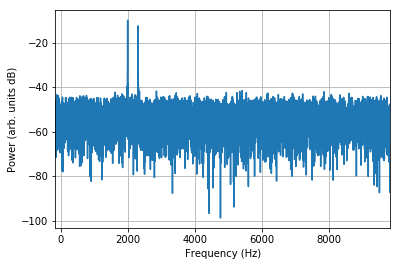

In [295]:
fshift = -(FINE_FFT_LENGTH/2-hsov+1)
fbins_os = np.arange(0,channel_bins) + fshift
faxis_os = fbins_os*fs_os/FINE_FFT_LENGTH
plt.plot(faxis_os, 20*log10(abs(os_pfb_stitch)))
plt.xlim([min(faxis_os), max(faxis_os)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb. units dB)')
plt.grid()
plt.show()